In [215]:
import duckdb
import matplotlib.pyplot as plt
from pathlib import Path


## opens a WAL file to work with when you open conn, to keep it open, 
## just remember to do a conn.close at the end to close it.

## i did this so i can sort each task on the same cell
## using the code you showed during class would "force" me to place all queries in the first notebook cell
## i found this to be more readable

duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

conn = duckdb.connect(duckdb_path)

with open("sql/load_sakila.sql") as f:
    conn.sql(f.read())

TASK 1

In [216]:
## a) Movies longer than 3 hours

long_movies = conn.sql("""
    SELECT title, length
    FROM film
    WHERE length > 180
    """).df()
##has 38 entries, but doin head (top5) for a shorter notebook for the assignment
long_movies.head() 

,title,length
0,ANALYZE HOOSIERS,181
1,BAKED CLEOPATRA,182
2,CATCH AMISTAD,183
3,CHICAGO NORTH,185
4,CONSPIRACY SPIRIT,184


In [217]:
## b) Movies with "love" in title

## used LLM to find the correct regex match. was fooling around on regex101 website but gave up after an hour.

love_movies = conn.sql("""
    SELECT title, rating, length, description
FROM film
WHERE REGEXP_MATCHES(LOWER(title), '\\blove\\b')
""").df()

love_movies.head()

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


In [218]:
## c) Descriptive statistics on movie length

## TODO: unsure if this is the actual thing we are looking for.

stats = conn.sql("""
    SELECT
        MIN(length) AS shortest,
        AVG(length) AS average,
        MEDIAN(length) AS median,
        MAX(length) AS longest
    FROM film
""").df()

stats.head()

,shortest,average,median,longest
0,46,115.272,114.0,185


In [219]:
## d) 10 most expensive movies per day
## this will get different answers depending on if you do head(10), or just do a limit 10
## so im unsure what the correct one is, since the cost per day is the same for more than 10

## im doin the LIMIT 10 instead of the pandas .head(10), there is a slight difference in how SQL and pandas work.
## can add DESC, title DESC/ASC -- to make sure it always follows the same order.

expensive_per_day = conn.sql("""
    SELECT
        title,
        rental_rate / rental_duration AS cost_per_day
    FROM film
    ORDER BY cost_per_day DESC
""").df()

expensive_per_day.head(10) 

,title,cost_per_day
0,PATHS CONTROL,1.663333
1,BACKLASH UNDEFEATED,1.663333
2,BEHAVIOR RUNAWAY,1.663333
3,VIRTUAL SPOILERS,1.663333
4,TEEN APOLLO,1.663333
5,TELEGRAPH VOYAGE,1.663333
6,BILKO ANONYMOUS,1.663333
7,HEARTBREAKERS BRIGHT,1.663333
8,CLERKS ANGELS,1.663333
9,TIES HUNGER,1.663333


In [220]:
## e) Top 10 actors by number of movies

## Had to use LLM to ask about the different selects to get a.first_name || ' ' || a.last_name, 
## had forgotten the whitespace in my own query.

top_actors = conn.sql("""
    SELECT 
        a.actor_id,
        a.first_name || ' ' || a.last_name AS actor_name,
        COUNT(*) AS film_count
    FROM actor a
    JOIN film_actor fa ON fa.actor_id = a.actor_id
    GROUP BY a.actor_id, actor_name
    ORDER BY film_count DESC
""").df()

top_actors.head(10)


,actor_id,actor_name,film_count
0,107.0,GINA DEGENERES,42
1,102.0,WALTER TORN,41
2,198.0,MARY KEITEL,40
3,181.0,MATTHEW CARREY,39
4,23.0,SANDRA KILMER,37
5,81.0,SCARLETT DAMON,36
6,37.0,VAL BOLGER,35
7,60.0,HENRY BERRY,35
8,13.0,UMA WOOD,35
9,144.0,ANGELA WITHERSPOON,35


## Own questions

## Q 1

In [221]:

film_rating = conn.sql("""SELECT
    rating,
    COUNT(*) AS number_of_movies
FROM film
GROUP BY rating
ORDER BY number_of_movies DESC
""").df()

film_rating.head()

,rating,number_of_movies
0,PG-13,223
1,NC-17,210
2,R,195
3,PG,194
4,G,178


##  Q 2

In [222]:
avg_leng_per_movie_rating = conn.sql("""SELECT
    rating,
    ROUND(AVG(length), 1) AS avg_length
FROM film
GROUP BY rating
ORDER BY avg_length DESC
""").df()

avg_leng_per_movie_rating.head()

,rating,avg_length
0,PG-13,120.4
1,R,118.7
2,NC-17,113.2
3,PG,112.0
4,G,111.1


## Q 3

In [223]:
rented_movies_by_customer = conn.sql("""SELECT
    c.first_name,
    c.last_name,
    COUNT(r.rental_id) AS total_rentals
FROM customer c
JOIN rental r ON c.customer_id = r.customer_id
GROUP BY c.customer_id, c.first_name, c.last_name
ORDER BY total_rentals DESC
""").df()

rented_movies_by_customer.head()

,first_name,last_name,total_rentals
0,ELEANOR,HUNT,46
1,KARL,SEAL,45
2,MARCIA,DEAN,42
3,CLARA,SHAW,42
4,TAMMY,SANDERS,41


## TASK 2 Graphs matplotlib

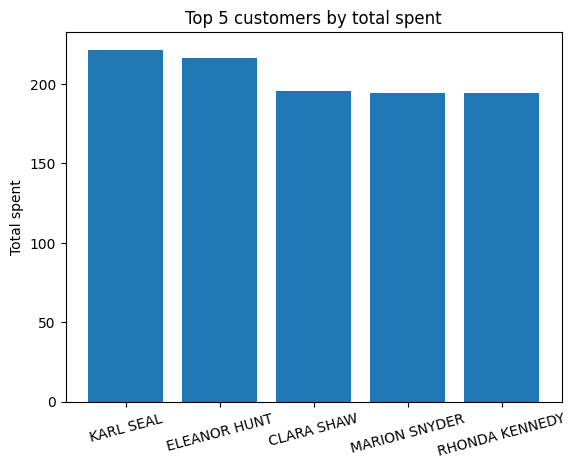

In [224]:
## a) Top 5 customers by total spend

## names overlapped, asked LLM how to fix it, gave me the suggestion of using xticks to rotate the names.

top_customers = conn.sql("""
    SELECT
        c.first_name || ' ' || c.last_name AS customer,
        SUM(p.amount) AS total_spent
    FROM customer c
    JOIN payment p ON c.customer_id = p.customer_id
    GROUP BY customer
    ORDER BY total_spent DESC
    LIMIT 5
""").df()

plt.figure()
plt.bar(top_customers["customer"], top_customers["total_spent"])
plt.title("Top 5 customers by total spent")
plt.ylabel("Total spent")
plt.xticks(rotation=15)
plt.show()

In [ ]:
## b) Revenue per film category

In [225]:
## Closing the connection, the current way im doin it is just keeping the connection open,
## untill i close it, it makes a .wal file of the DB, need to close it when done.
## makes it so i dont have to re-establish a connection with each query. 
## just make sure you close it when done.

conn.close()